## $R_t$ Change Point Detection
## Shaman Group Meeting
### 2023/01/31
### Han Yong Wunrow

In [1]:
import os

import pickle
import re
import arviz as az

import pandas as pd
import numpy as np

basepath = 'C:\\Users\\hyone\\Documents\\GitHub\\rt-estimation\\data'
dirs = os.listdir(basepath)
search_dirs = [dir for dir in dirs if '2023-01-26' in dir]

import importlib
import sys
sys.path.insert(0, 'C:\\Users\\hyone\\Documents\\GitHub\\rt-estimation\\src')
import model

search_dir = search_dirs[-1]


In [2]:
with open(f'{basepath}/{search_dir}/model.pkl', 'rb') as file:
    sir_model = pickle.load(file)

vars = re.findall(r'\[\'.*?\'\]', search_dir)[0][2:-2].split("\', \'")

hdi = az.hdi(sir_model.trace, var_names=vars, hdi_prob = 0.95).to_dataframe()

data = {}
for var in vars:
    true_var = getattr(sir_model.data, var)
    # print(var)
    # print(hdi[var]['lower'])
    # print(hdi[var]['higher'])
    # print(f"In HDI? {(hdi[var]['lower'] <= true_var) & (true_var <= hdi[var]['higher'])}")
    data = data | {
        f'{var}_lower': [hdi[var]['lower']],
        f'{var}_higher': [hdi[var]['higher']],
        f'{var}_true': [true_var]
    }
df = pd.DataFrame.from_dict(data)
df['directory'] = search_dir
df['inferred parameters'] = str(vars)
df['num inferred parameters'] = len(vars)

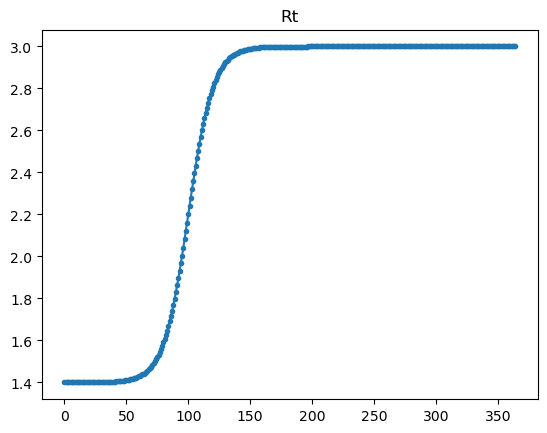

In [3]:
sir_model.data.plot_rt()

### Time-varying Reproduction Number
* $R_t$: the average number of secondary cases caused by an infectious individual in a well-mixed population of susceptible individuals at time $t$
* Kalman filters (and other sequential methods) may difficulty in modelling when there are abrupt changes in hyperparameters
* May gain improvements by deconstructing into local models separated by changepoints
* Can we identify changepoints from surveillance data

### Synthetic Data

SIR model
\begin{array}{l}
\frac{d S}{d t}=-\frac{\beta(t) I S}{N} \\
\frac{d I}{d t}=\frac{\beta(t) I S}{N}-\gamma I, \\
\frac{d R}{d t}=\gamma I
\end{array}

* Fixed $\gamma = 1/4$
* $N$ = 100,000
* $I_0$ = 100

$$
R_t=R^{\text {before }}+\frac{R^{a f t e r}-R^{b e f o r e}}{1+e^{-k(t-m)}}
$$

* $R^{\text {before }}$ = 1.4
* $R^{a f t e r}$ = 3
* $midpoint$ = 100
* $k$ = 0.1


* $\beta(t) = \gamma R_t$

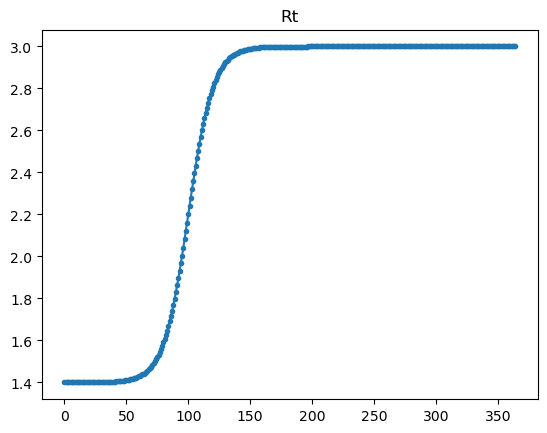

In [4]:
sir_model.data.plot_rt()

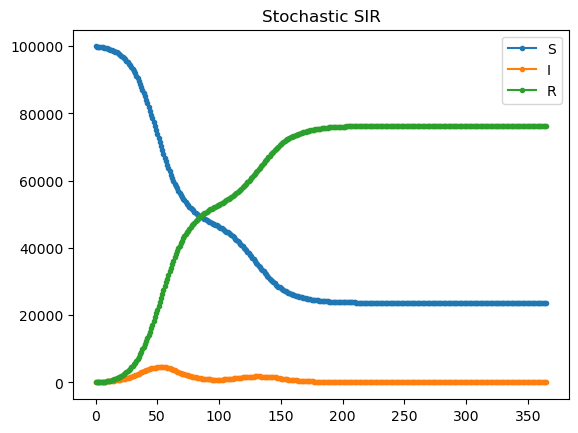

In [5]:
sir_model.data.plot_SIR()

### Synthetic Data
* Generate with Poisson Process
* Integrated with Forward Euler with dt=1
* Added observational error Gaussian noise with mean 0 and variance proportional to reported cases

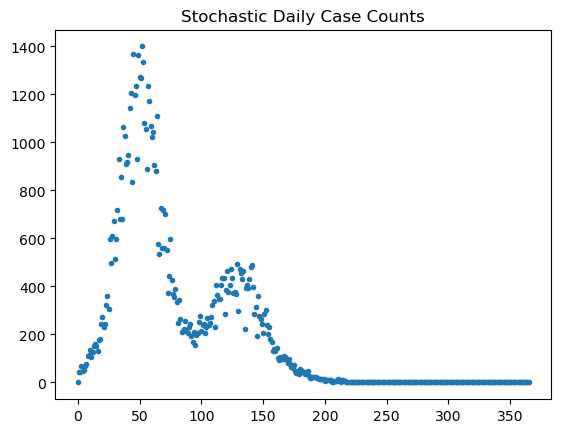

In [6]:
sir_model.data.plot_obs()

### Priors
- $R^{\text {before }} \sim \text{U}\left(1, 4\right)$
- $R^{a f t e r} \sim \text{U}\left(1.5, 4\right)$
- $k \sim \text{U}(0.01, 2)$
- $midpoint \sim \text{DiscreteUnif}\left(30, 200\right)$
- $I_0 \sim \text{Poisson}(50)$

Truth
* $R^{\text {before }}$ = 1.4
* $R^{a f t e r}$ = 3
* $k$ = 0.1
* $midpoint$ = 100
* $I_0$ = 100



### Likelihood

1. $\operatorname{Pr}\left(\hat{i}_t \mid i_t, \theta\right) \sim \operatorname{StudentT}\left(\operatorname{df} = \nu, \mu=i_t, \sigma=\hat{\sigma} i_t\right) = \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right)}\left(\frac{1}{\sigma^2 \pi \nu}\right)^{\frac{1}{2}}\left[1+\frac{(x-\mu)^2}{\sigma^2\nu}\right]^{-\frac{\nu+1}{2}}$
2. $\operatorname{Pr}\left(\hat{i}_t \mid i_t, \theta\right) \sim \mathcal{N}\left(\mu=i_t, \sigma=\hat{\sigma} i_t\right)$

where

- $\hat{\sigma} \sim \operatorname{HalfCauchy}(\beta = 10) = \frac{2}{\pi \beta\left[1+\left(\frac{x}{\beta}\right)^2\right]}$

and where $\hat{i}_t$ is the estimate daily reported cases, $i_t$ is the daily reported cases from our synthetic data, and the current sample $\theta=\left\{R^{b e f o r e}, R^{a f t e r}, k, m\right\}$.

3. $\operatorname{Pr}\left(\hat{i}_t \mid i_t, \theta\right) \sim \operatorname{NB}(\mu = i_t, \alpha=\hat{\alpha}) = \left(\begin{array}{c} x+\alpha-1 \\ x\end{array}\right)(\alpha /(\mu+\alpha))^\alpha(\mu /(\mu+\alpha))^x$

where

- $1/\hat{\alpha} \sim \mathcal{N}\left(\mu=0, \sigma=0.5\right)$

### MCMC
* Ran with `pymc 5.0.1`
* Burn in: 1,000, Draws: 5,000
* 4 independent chains
* Metropolis-Hastings: $I_0$ and $midpoint$, NUTS: $R^{\text {before }}, R^{\text {after }}, k$
* `pymc` tunes MCMC hyperparameters (e.g., step size $\rho_n$) during burn in phase 
    * satisfies Robbins-Monro
    $$
    \sum_{n=0}^{\infty} \rho_n=\infty \quad \text { and } \quad \sum_{n=0}^{\infty} \rho_n^2<\infty
    $$
* Outputs results as `xarray` (netCDF files)

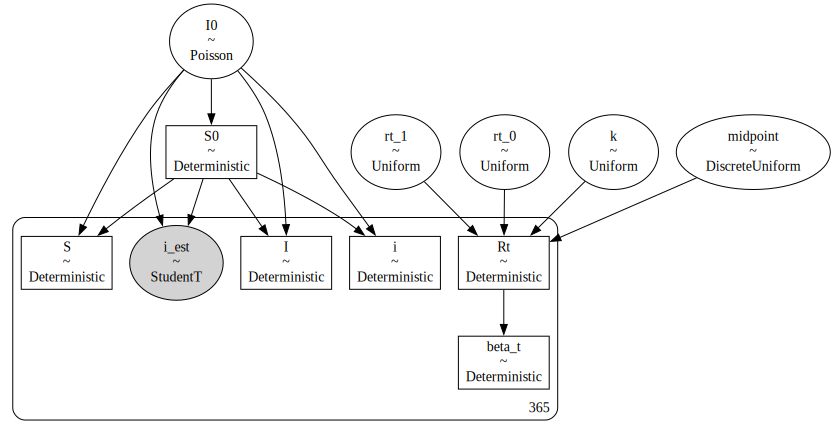

In [8]:
import pymc as pm
pm.model_to_graphviz(sir_model.model)

### Initial Results

In [43]:
summary_df, acc_rate = sir_model.sample_stats(vars)
display(summary_df)
display(acc_rate)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
rt_0        1.42  0.01    1.40     1.43       0.00     0.00    1343.0   
rt_1        2.88  0.10    2.70     3.06       0.00     0.00     737.0   
k           0.14  0.02    0.11     0.17       0.00     0.00     650.0   
midpoint   97.81  0.55   97.00    99.00       0.03     0.02     337.0   
I0        103.24  4.88   93.00   111.00       0.16     0.11     947.0   

          ess_tail  r_hat  truth  
rt_0        2657.0   1.00    1.4  
rt_1        1471.0   1.01    3.0  
k           1170.0   1.01    0.1  
midpoint     331.0   1.01  100.0  
I0          1914.0   1.00  100.0

array([[0.371 , 0.4744],
       [0.364 , 0.4338],
       [0.3702, 0.4368],
       [0.3864, 0.5484]])

array([[<AxesSubplot: title={'center': 'rt_0'}>,
        <AxesSubplot: title={'center': 'rt_0'}>],
       [<AxesSubplot: title={'center': 'rt_1'}>,
        <AxesSubplot: title={'center': 'rt_1'}>],
       [<AxesSubplot: title={'center': 'k'}>,
        <AxesSubplot: title={'center': 'k'}>],
       [<AxesSubplot: title={'center': 'midpoint'}>,
        <AxesSubplot: title={'center': 'midpoint'}>],
       [<AxesSubplot: title={'center': 'I0'}>,
        <AxesSubplot: title={'center': 'I0'}>]], dtype=object)

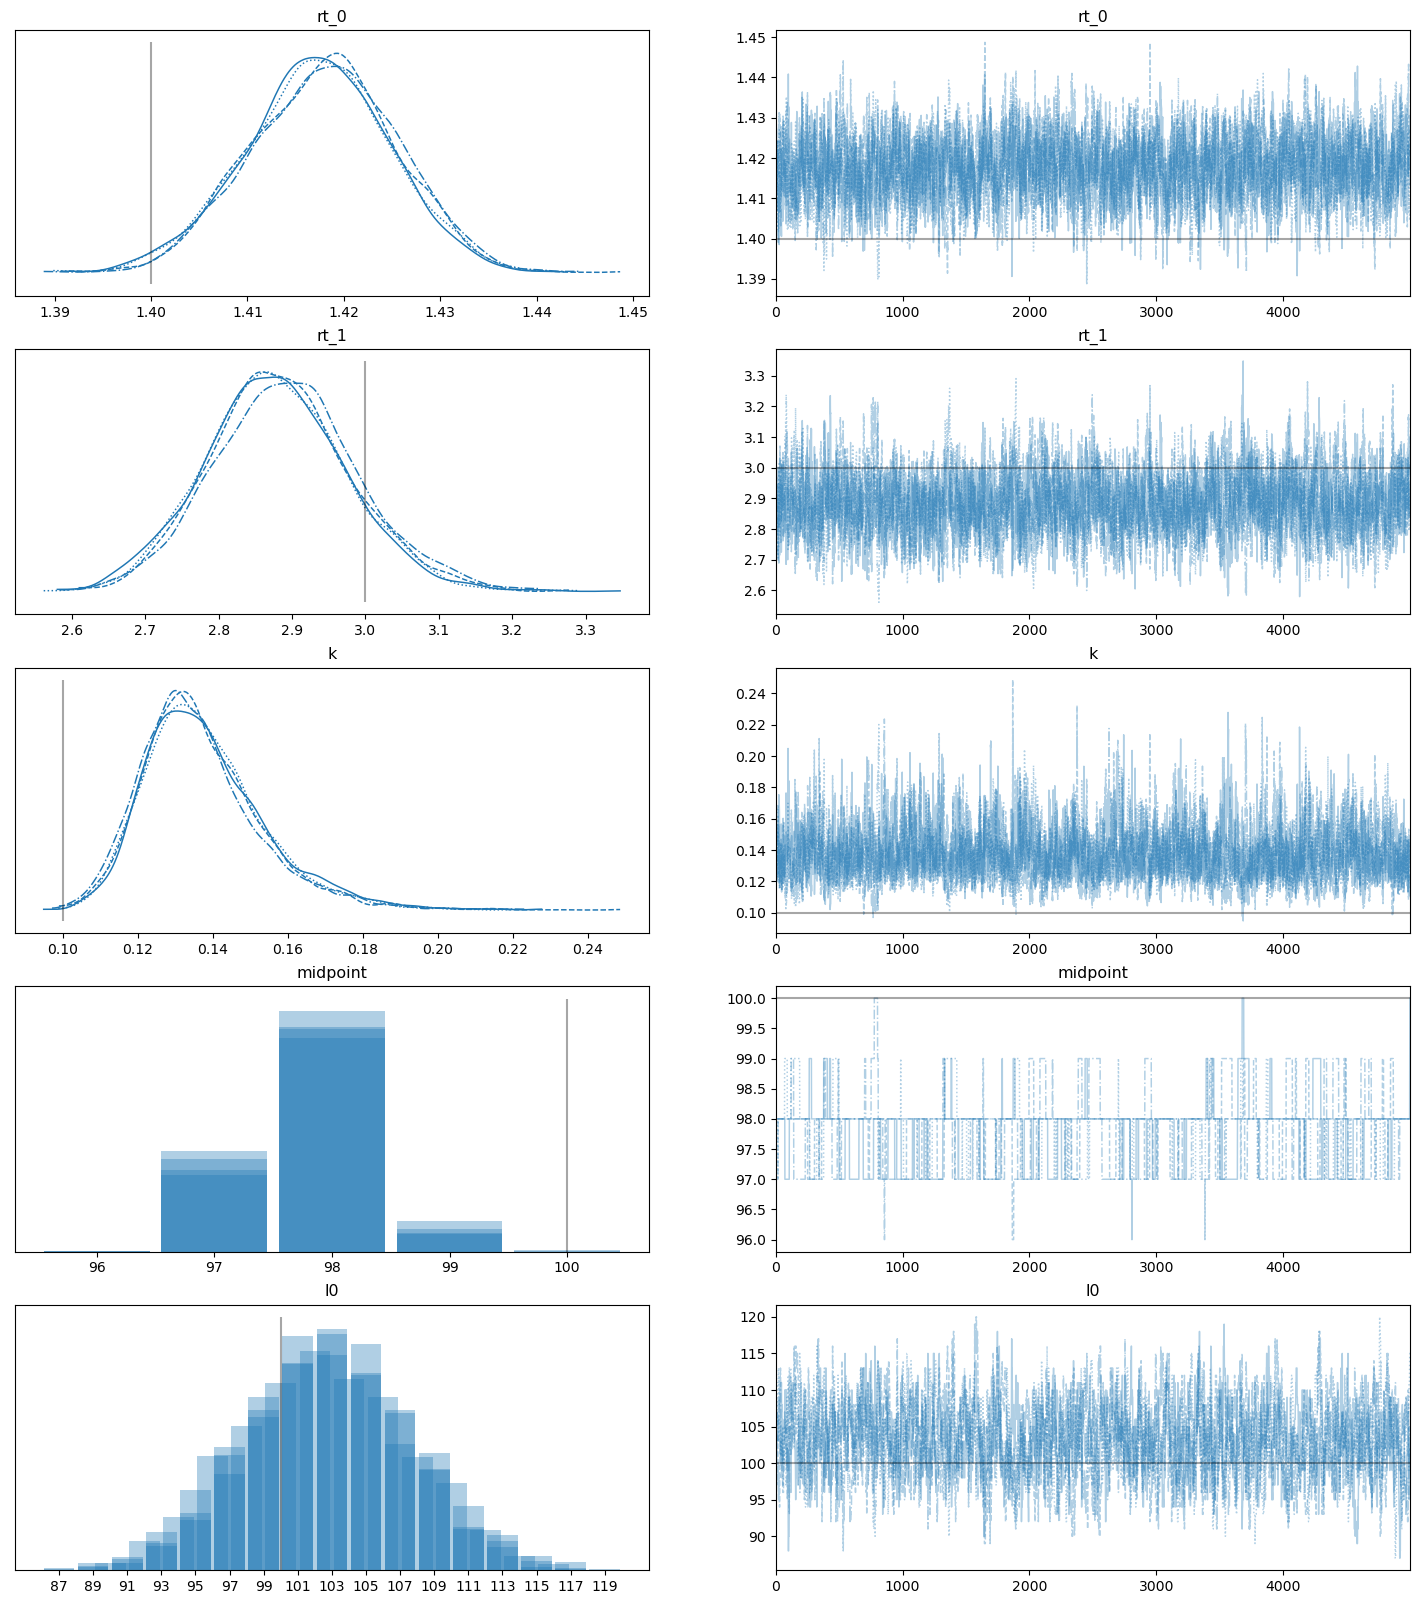

In [28]:
sir_model.plot_trace(vars)

array([[<AxesSubplot: title={'center': 'i'}>,
        <AxesSubplot: title={'center': 'i'}>]], dtype=object)

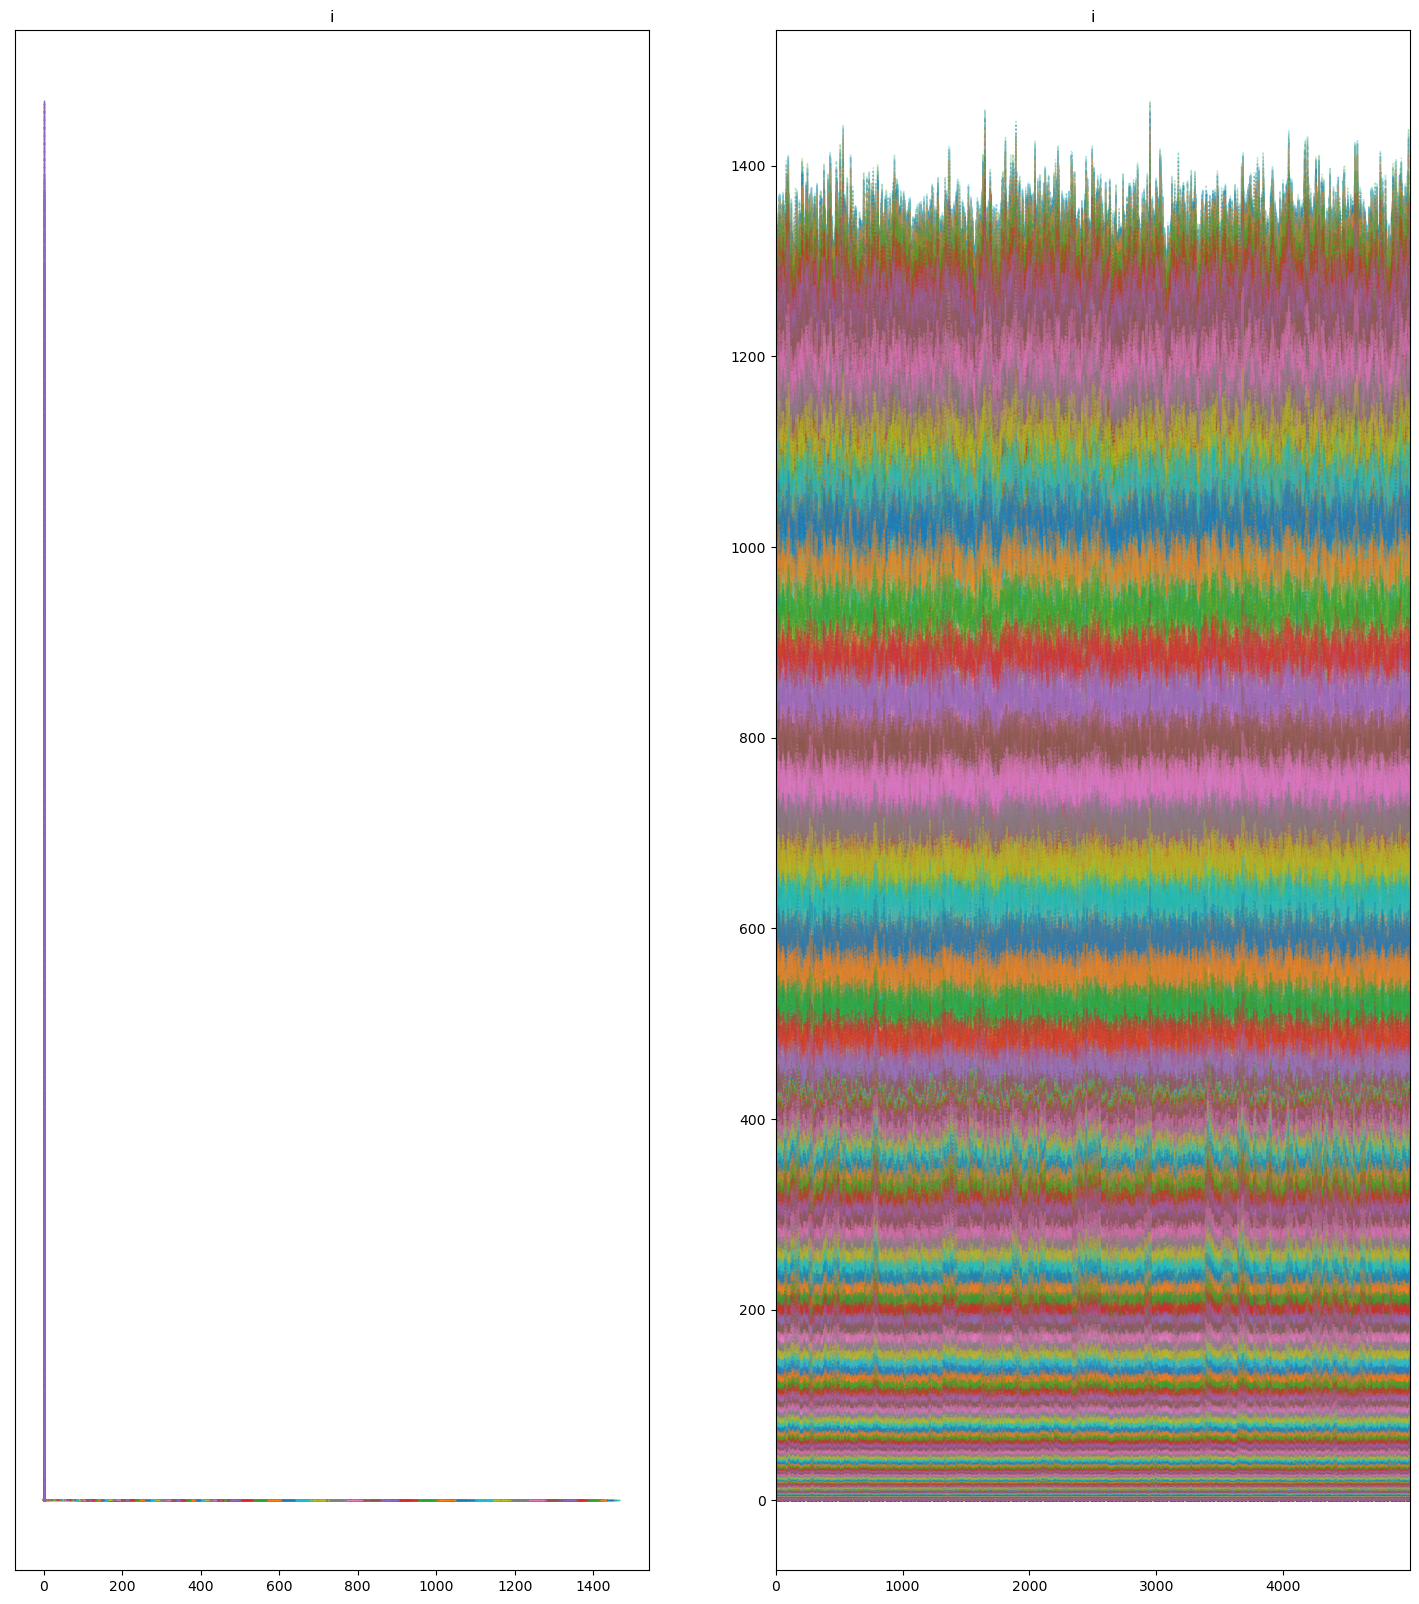

In [30]:
import arviz as az

az.plot_trace(sir_model.trace, var_names=["i"],figsize=(18, 20))

array([[<AxesSubplot: title={'center': 'rt_0'}>,
        <AxesSubplot: title={'center': 'rt_1'}>,
        <AxesSubplot: title={'center': 'k'}>],
       [<AxesSubplot: title={'center': 'midpoint'}>,
        <AxesSubplot: title={'center': 'I0'}>, <AxesSubplot: >]],
      dtype=object)

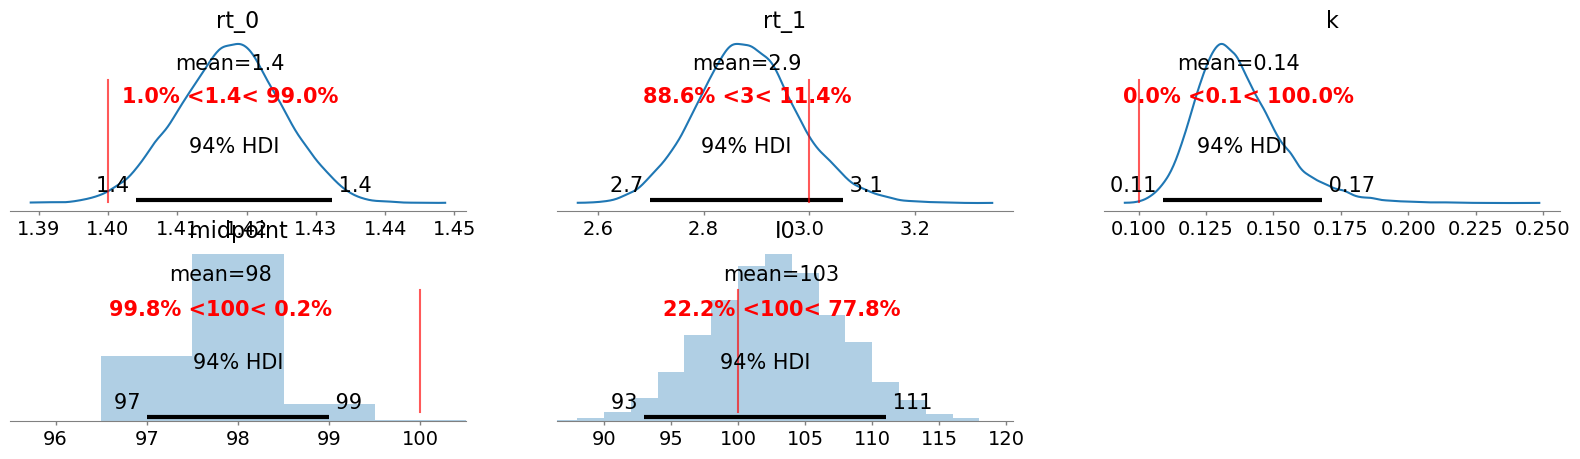

In [32]:
sir_model.plot_posterior(vars)

array([[<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: xlabel='rt_0'>],
       [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: xlabel='rt_1'>],
       [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: xlabel='k'>],
       [<AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: xlabel='midpoint'>],
       [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: xlabel='I0'>]],
      dtype=object)

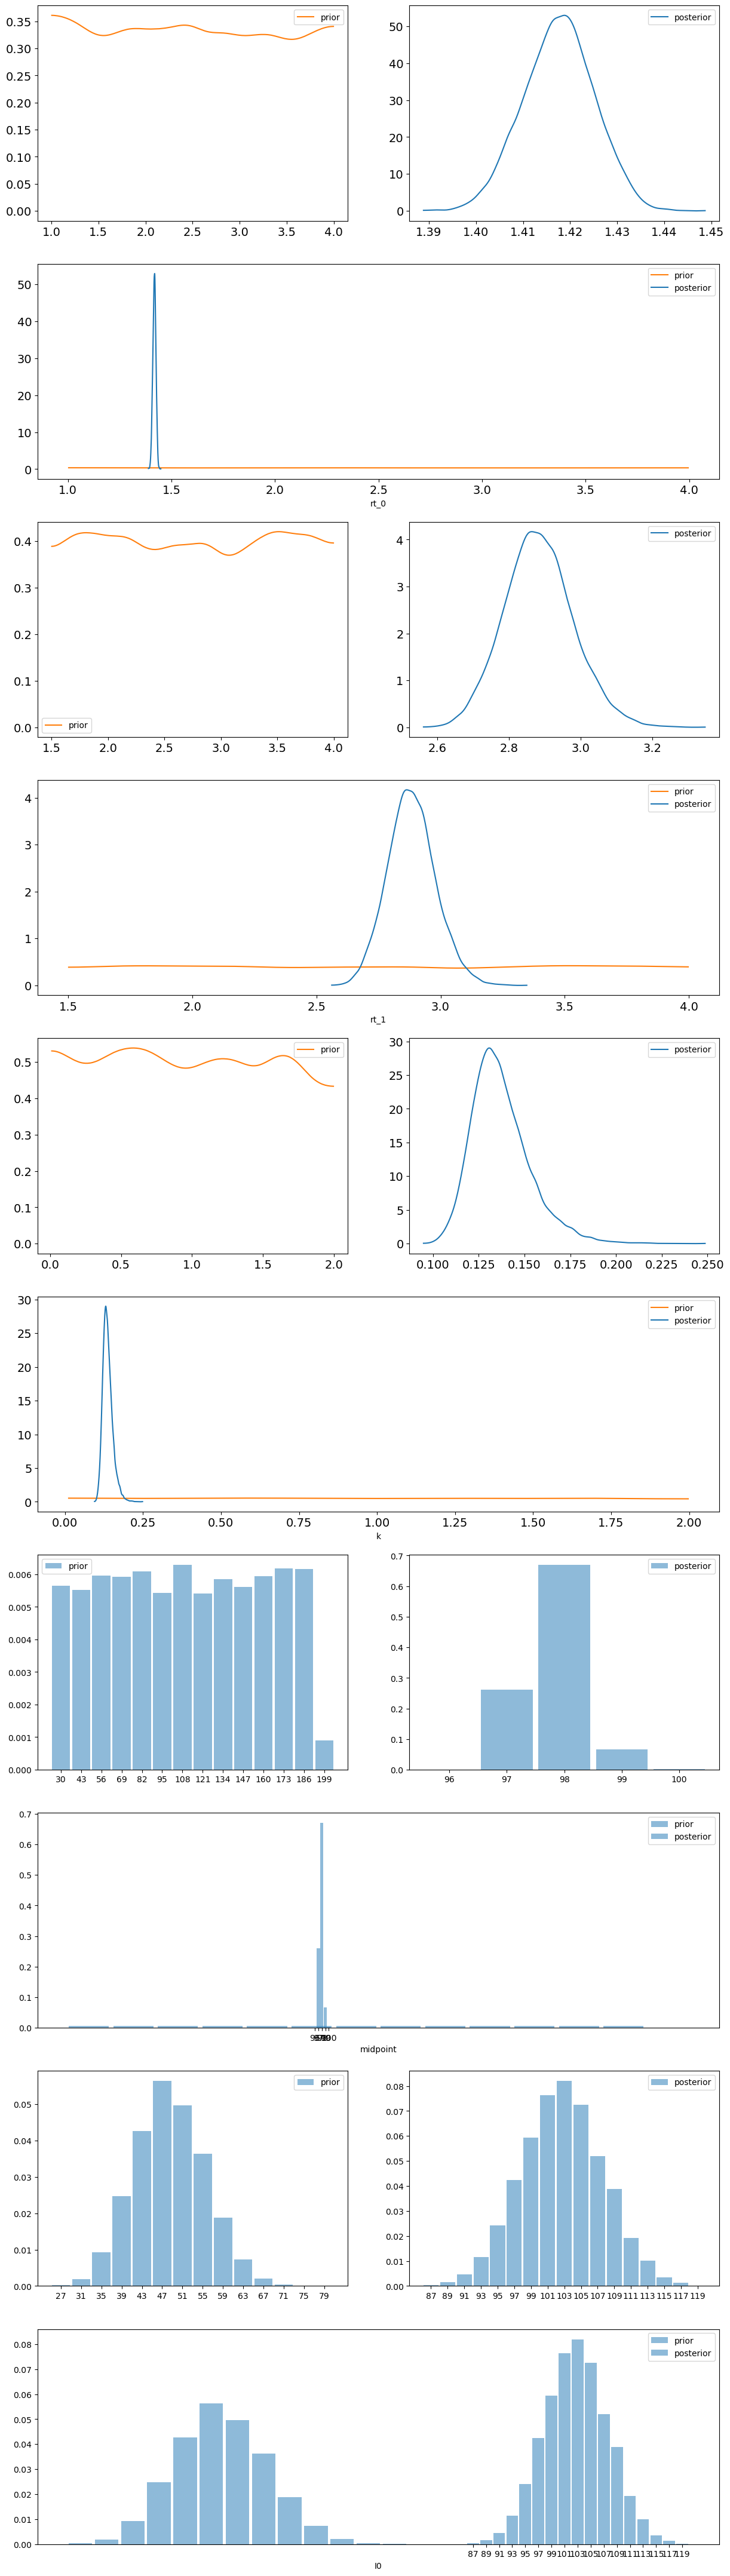

In [40]:
sir_model.plot_prior_posterior(vars)

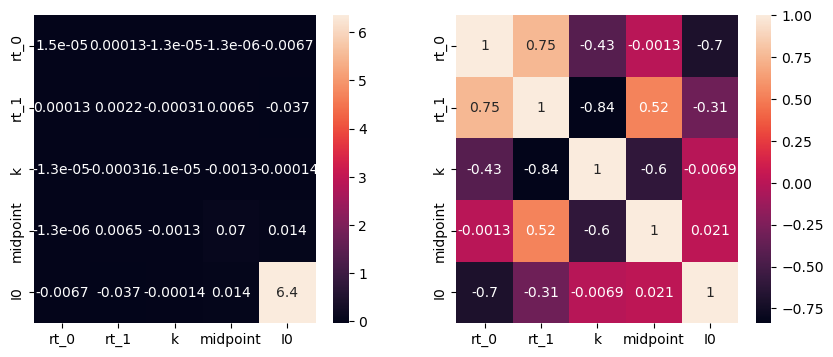

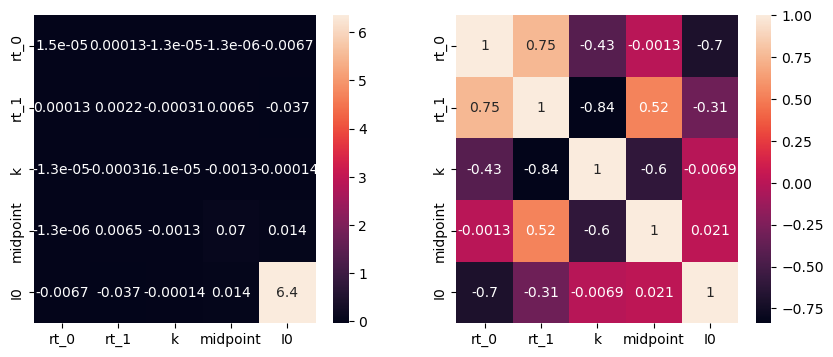

In [41]:
sir_model.plot_cov_corr(vars)

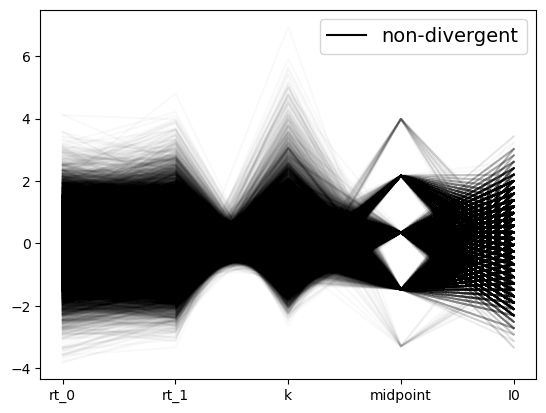

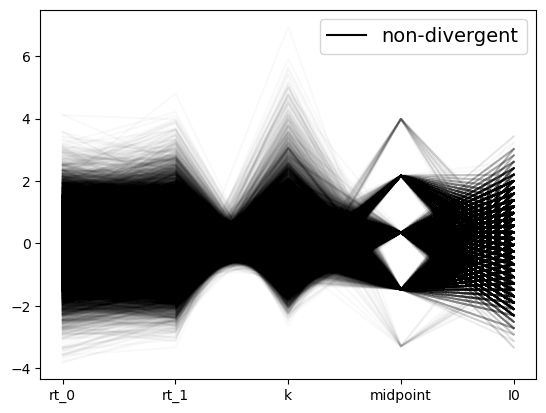

In [36]:
sir_model.plot_parallel_coord(vars)

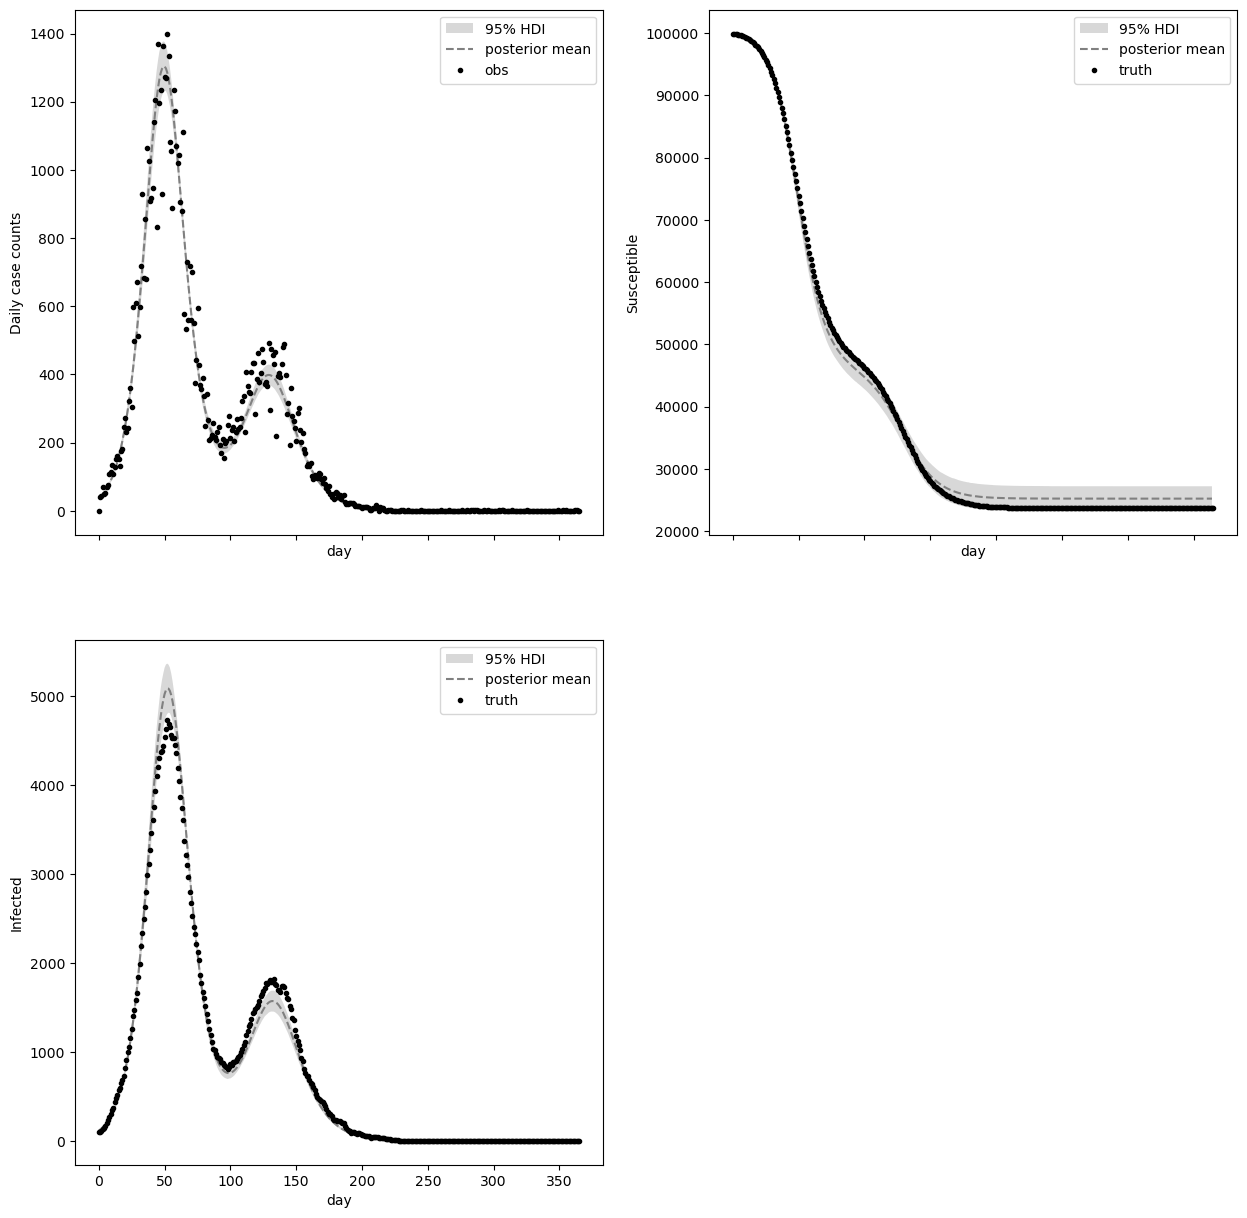

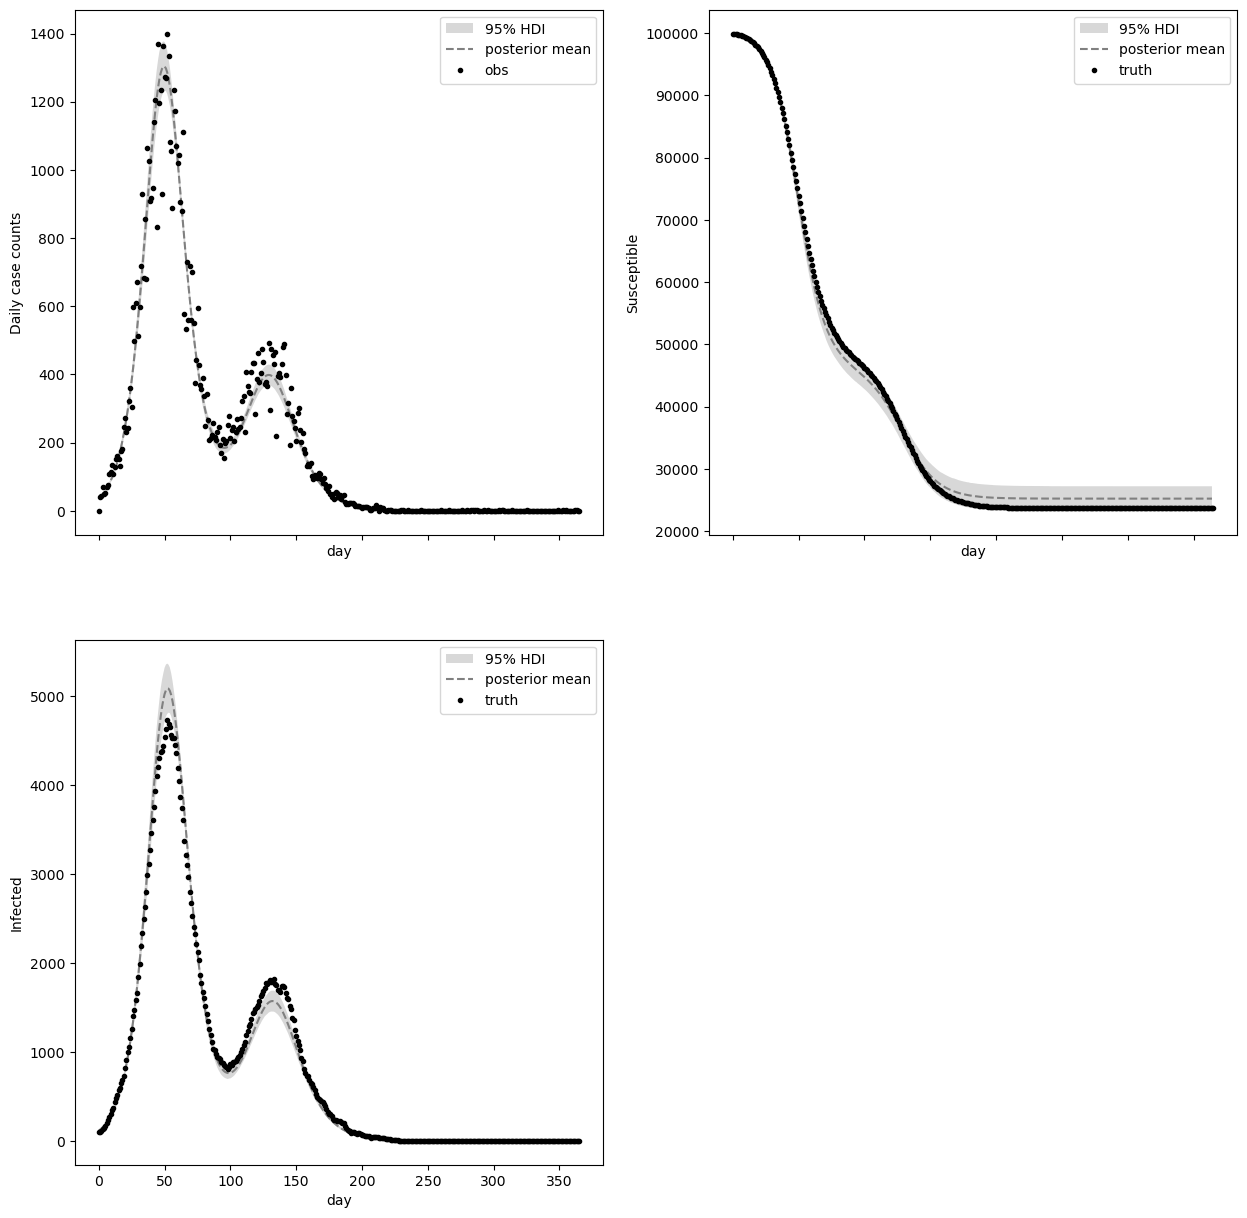

In [37]:
sir_model.plot_sir()

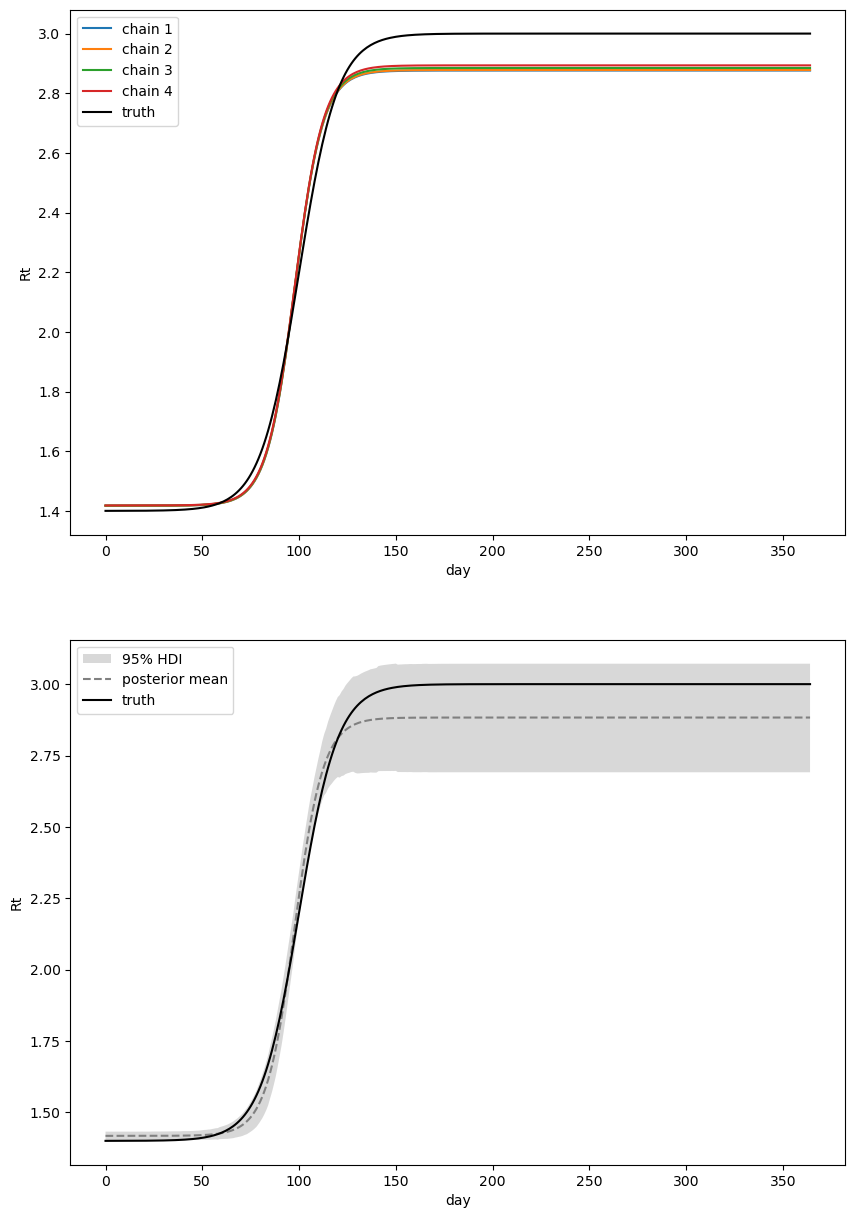

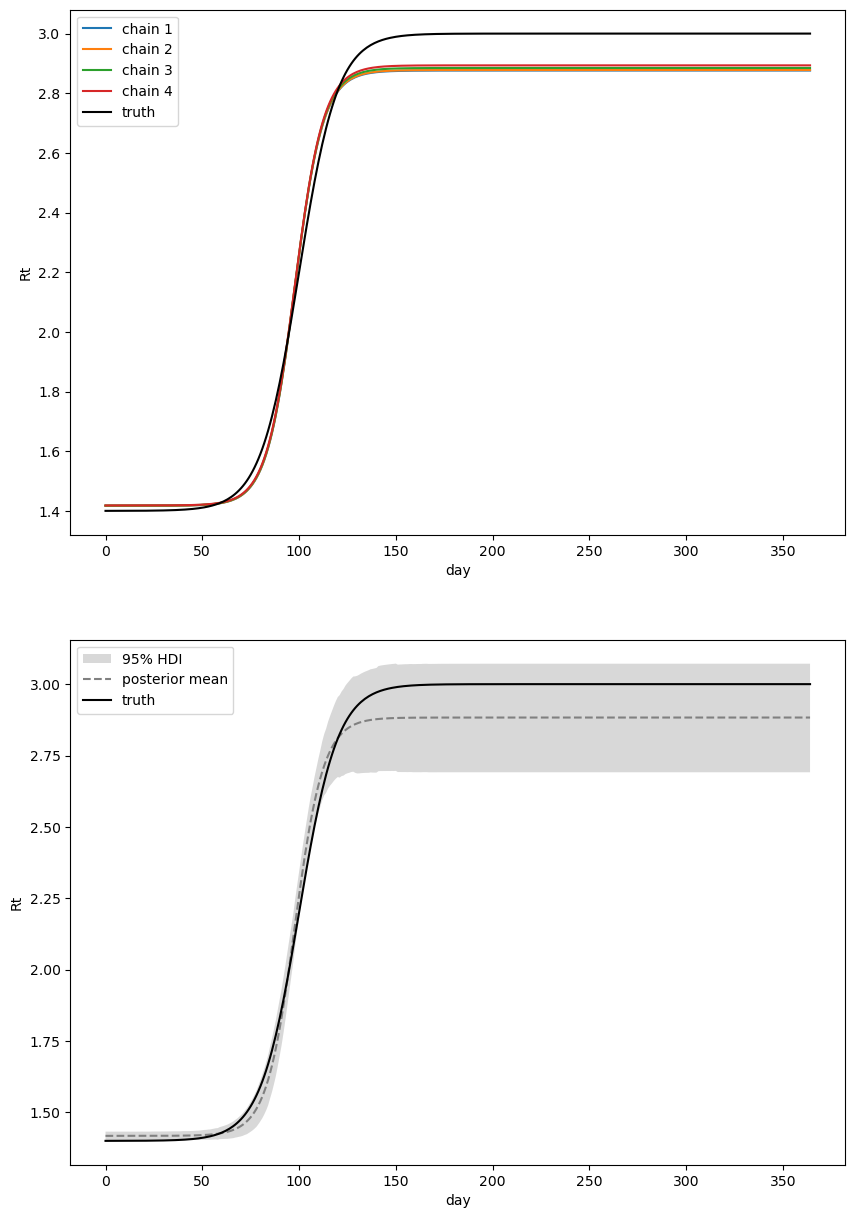

In [38]:
sir_model.plot_rt()

### Next Steps
* Make 0.2 scale a random variable and infer
* Expand change point detection to work online
* Compare results and combine with Kalman/ particle filter
* Standard data processing steps with real data (delay, unreported cases, etc.)